## FIAPHackathon
Grupo 46 POS TECH - Hackathon

### Detecção de materiais cortantes    

A FIAP VisionGuard, empresa de monitoramento de câmeras de segurança, está analisando a viabilidade de uma nova funcionalidade para otimizar o seu software.  
O objetivo da empresa é usar de novas tecnologias para identificar situações atípicas e que possam colocar em risco a segurança de  estabelecimentos e comércios que utilizam suas câmeras.  
Um dos principais desafios da empresa é utilizar Inteligência Artificial para identificar objetos cortantes (facas, tesouras e similares) e emitir alertas para a central de segurança.  
A empresa tem o objetivo de validar a viabilidade dessa feature, e para isso, será necessário fazer um MVP para detecção supervisionada desses objetos. 

### Objetivos 
* Construir ou buscar um dataset contendo imagens de facas, tesouras e outros objetos cortantes em diferentes condições de ângulo e iluminação; 
* Anotar o dataset para treinar o modelo supervisionado, incluindo imagens negativas (sem objetos perigosos) para reduzir falsos positivos; 
* Treinar o modelo; 
* Desenvolver um sistema de alertas (pode ser um e-mail). 

### Utilização do modelo customizado treinado.
Após o treinamento realizado no notebook anterior é possível utilizar o modelo treinado para realizar a detecção de objetos em imagens.

Se efetuar o download do modelo treinado, basta executar o código abaixo para realizar a detecção de objetos em uma imagem.

Caso efetue vários treinamentos o script irá gerar a pasta "output" sequencialmente, sendo ela, train, train1, train2, train3...

In [1]:
from ultralytics import YOLO
model = YOLO("runs/detect/train/weights/best.pt")

### Realizando inferencia com o modelo treinado
Para efetuar a inferência com o modelo treinado basta informar o diretório ou um aquivo específico. 

Lembre-se de mudar o device=0 para device='CPU' caso não tenha uma GPU disponível.

In [2]:
inference_results = model("datasets/test/images", device = 0, conf = 0.5)


image 1/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00001.jpg: 640x640 1 knife, 9.7ms
image 2/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00002.jpg: 640x640 1 knife, 10.0ms
image 3/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00003.jpg: 640x640 1 knife, 9.9ms
image 4/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00004.jpg: 640x640 1 knife, 9.8ms
image 5/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00005.jpg: 640x640 1 knife, 9.9ms
image 6/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00006.jpg: 640x640 1 knife, 9.7ms
image 7/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00007.jpg: 640x640 1 knife, 9.9ms
image 8/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00008.jpg: 640x640 1 knife, 9.6ms
image 9/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00009.jpg: 640x640 1 knife, 10.1ms
image 10/568 /mnt/c/workspace/FIAPHackathon/datasets/test/images/00010.jpg: 640x640 1 knife, 9.5ms
image 11/568 /mn

### Visualizando a inferência
Para visualizar a inferência criamos uma função que recebe como parâmetro o resultado da inferência realizada acima e faz o plot de algumas imagens aleatórias do dataset.

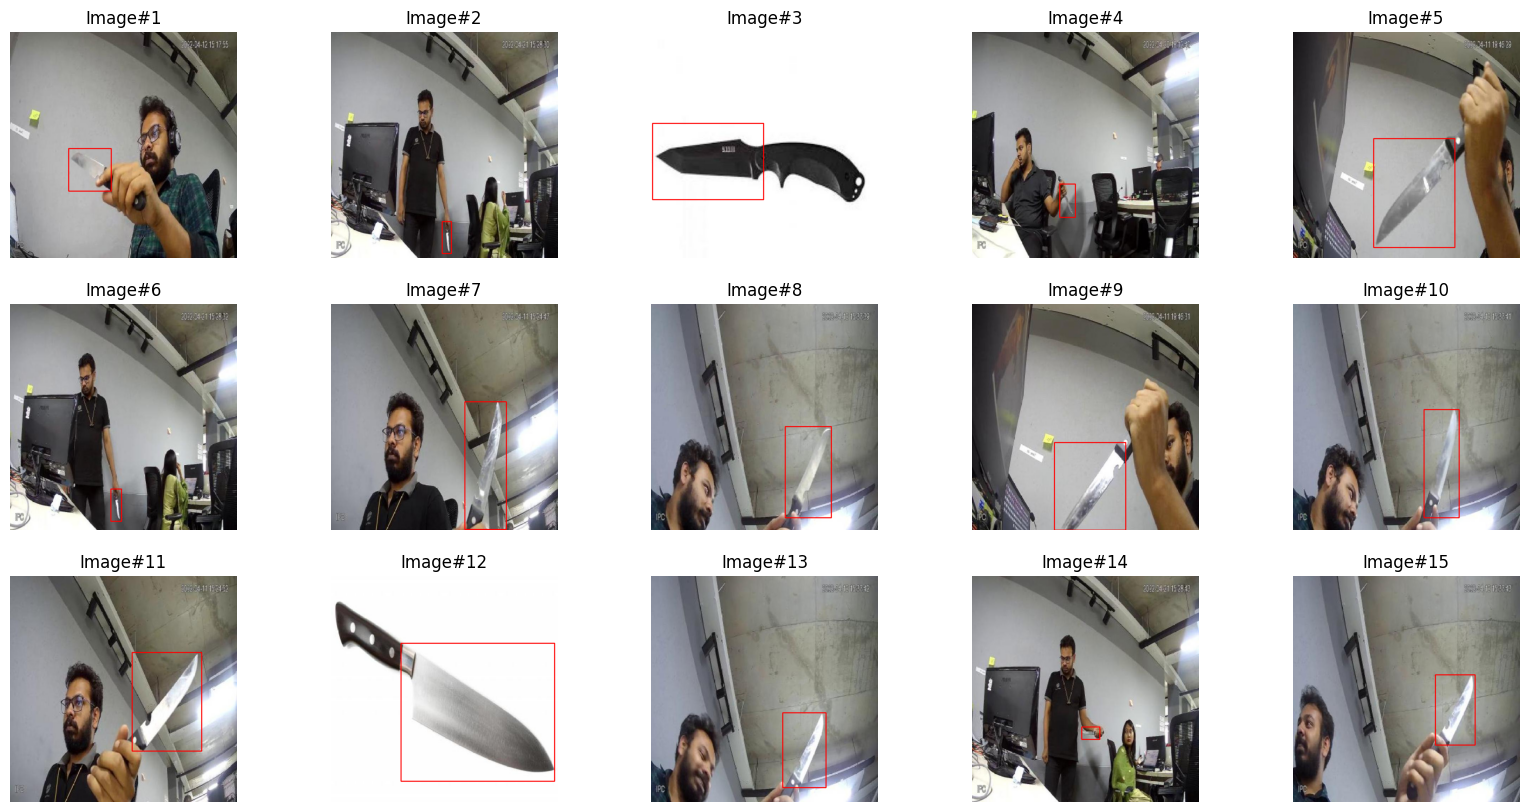

In [7]:
import cv2, yaml, random, numpy as np
from PIL import Image
from matplotlib import pyplot as plt

def inference_vis(res, n_ims, rows):
    import math
    
    # Close any existing figures
    plt.close('all')
    
    cols = math.ceil(n_ims / rows)
    plt.figure(figsize=(20, 10))
    
    for idx, r in enumerate(res):
        if idx == n_ims: break
        plt.subplot(rows, cols, idx + 1)
        or_im_rgb = np.array(Image.open(r.path).convert("RGB"))
        for i in r:
            for bbox in i.boxes:
                box = bbox.xyxy[0]
                x1, y1, x2, y2 = box
                coord1, coord2 = (int(x1), int(y1)), (int(x2), int(y2))
                cv2.rectangle(or_im_rgb, coord1, coord2, color=(255,0,0), thickness=2)
        plt.imshow(or_im_rgb)
        plt.title(f"Image#{idx + 1}")
        plt.axis("off")

inference_vis(res = inference_results, n_ims = 15, rows = 3)

### Envio de e-mail
A rotina de envio de e-mail foi implementada para enviar através do Gmail, contudo, nada impede que seja utilizado outro provedor de e-mail.

In [8]:
def send_detection_email(sender_email, sender_password, receiver_email, inference_results):
    import smtplib
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email.mime.image import MIMEImage
    import io
    import math
    from datetime import datetime

    # Filter only results with detections
    detected_results = []
    for result in inference_results:
        if result and len(result) > 0 and result[0] and len(result[0].boxes) > 0:
            detected_results.append(result)
    
    if not detected_results:
        print("No weapons detected in any image. No email sent.")
        return

    # Calculate number of emails needed
    total_images = len(detected_results)
    images_per_email = 5
    num_emails = math.ceil(total_images / (images_per_email * 15))  # 15 images per attachment, 5 attachments per email

    for email_num in range(num_emails):
        # Create message container
        msg = MIMEMultipart()
        msg['From'] = sender_email
        msg['To'] = receiver_email
        msg['Subject'] = f'FIAP VisionGuard - Weapon Detection Alert {email_num + 1}/{num_emails} - {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        # Create the body of the message
        start_idx = email_num * images_per_email * 15
        end_idx = min((email_num + 1) * images_per_email * 15, total_images)
        body = f'FIAP VisionGuard - Alert: Weapons detected - Batch {email_num + 1} of {num_emails}\nShowing detections {start_idx + 1} to {end_idx} of {total_images} total detections.'
        msg.attach(MIMEText(body, 'plain'))

        # Process batches for this email
        current_results = detected_results[start_idx:end_idx]
        batch_size = 15
        num_batches = min(5, math.ceil(len(current_results) / batch_size))

        for batch in range(num_batches):
            batch_start = batch * batch_size
            batch_end = min((batch + 1) * batch_size, len(current_results))
            current_batch = current_results[batch_start:batch_end]
            
            plt.close('all')
            plt.figure(figsize=(20, 10))
            inference_vis(current_batch, n_ims=len(current_batch), rows=3)
            
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            
            image = MIMEImage(buf.read())
            image.add_header('Content-ID', f'<detection_results_batch_{batch+1}>')
            image.add_header('Content-Disposition', f'attachment; filename="weapon_detection_email{email_num+1}_batch_{batch+1}.png"')
            msg.attach(image)
            plt.close()

        # Setup Microsoft 365 server
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        
        try:
            # Login and send email
            server.login(sender_email, sender_password)
            server.send_message(msg)
            print(f"Alert email sent successfully with {num_batches} attachments containing {total_images} detected weapons!")
        except Exception as e:
            print(f"Error sending email: {str(e)}")
        finally:
            server.quit()

### Envio de email
Para que o envio de e-mail funcione, é necessário que você tenha uma conta de e-mail gmail e seja criado uma App Password da conta. Os links a seguir podem auxiliar na criação da senha app do google: https://support.google.com/accounts/answer/185833?hl=pt-BR ou direto https://myaccount.google.com/apppasswords    

In [9]:

# Example usage
sender_email = "xxx@gmail.com" # sender mail address
sender_password = "xxxx aaaa bbbb cccc"  # Use App Password from Google Account
receiver_email = "xxx@fiap.com.br" # destination mail address 

send_detection_email(
    sender_email,
    sender_password,
    receiver_email,
    inference_results
)


Alert email sent successfully with 5 attachments containing 485 detected weapons!
Alert email sent successfully with 5 attachments containing 485 detected weapons!
Alert email sent successfully with 5 attachments containing 485 detected weapons!
Alert email sent successfully with 5 attachments containing 485 detected weapons!
Alert email sent successfully with 5 attachments containing 485 detected weapons!
Alert email sent successfully with 5 attachments containing 485 detected weapons!
Alert email sent successfully with 3 attachments containing 485 detected weapons!
